In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from typing import *
from IPython.display import Image

import warnings

warnings.filterwarnings('ignore')

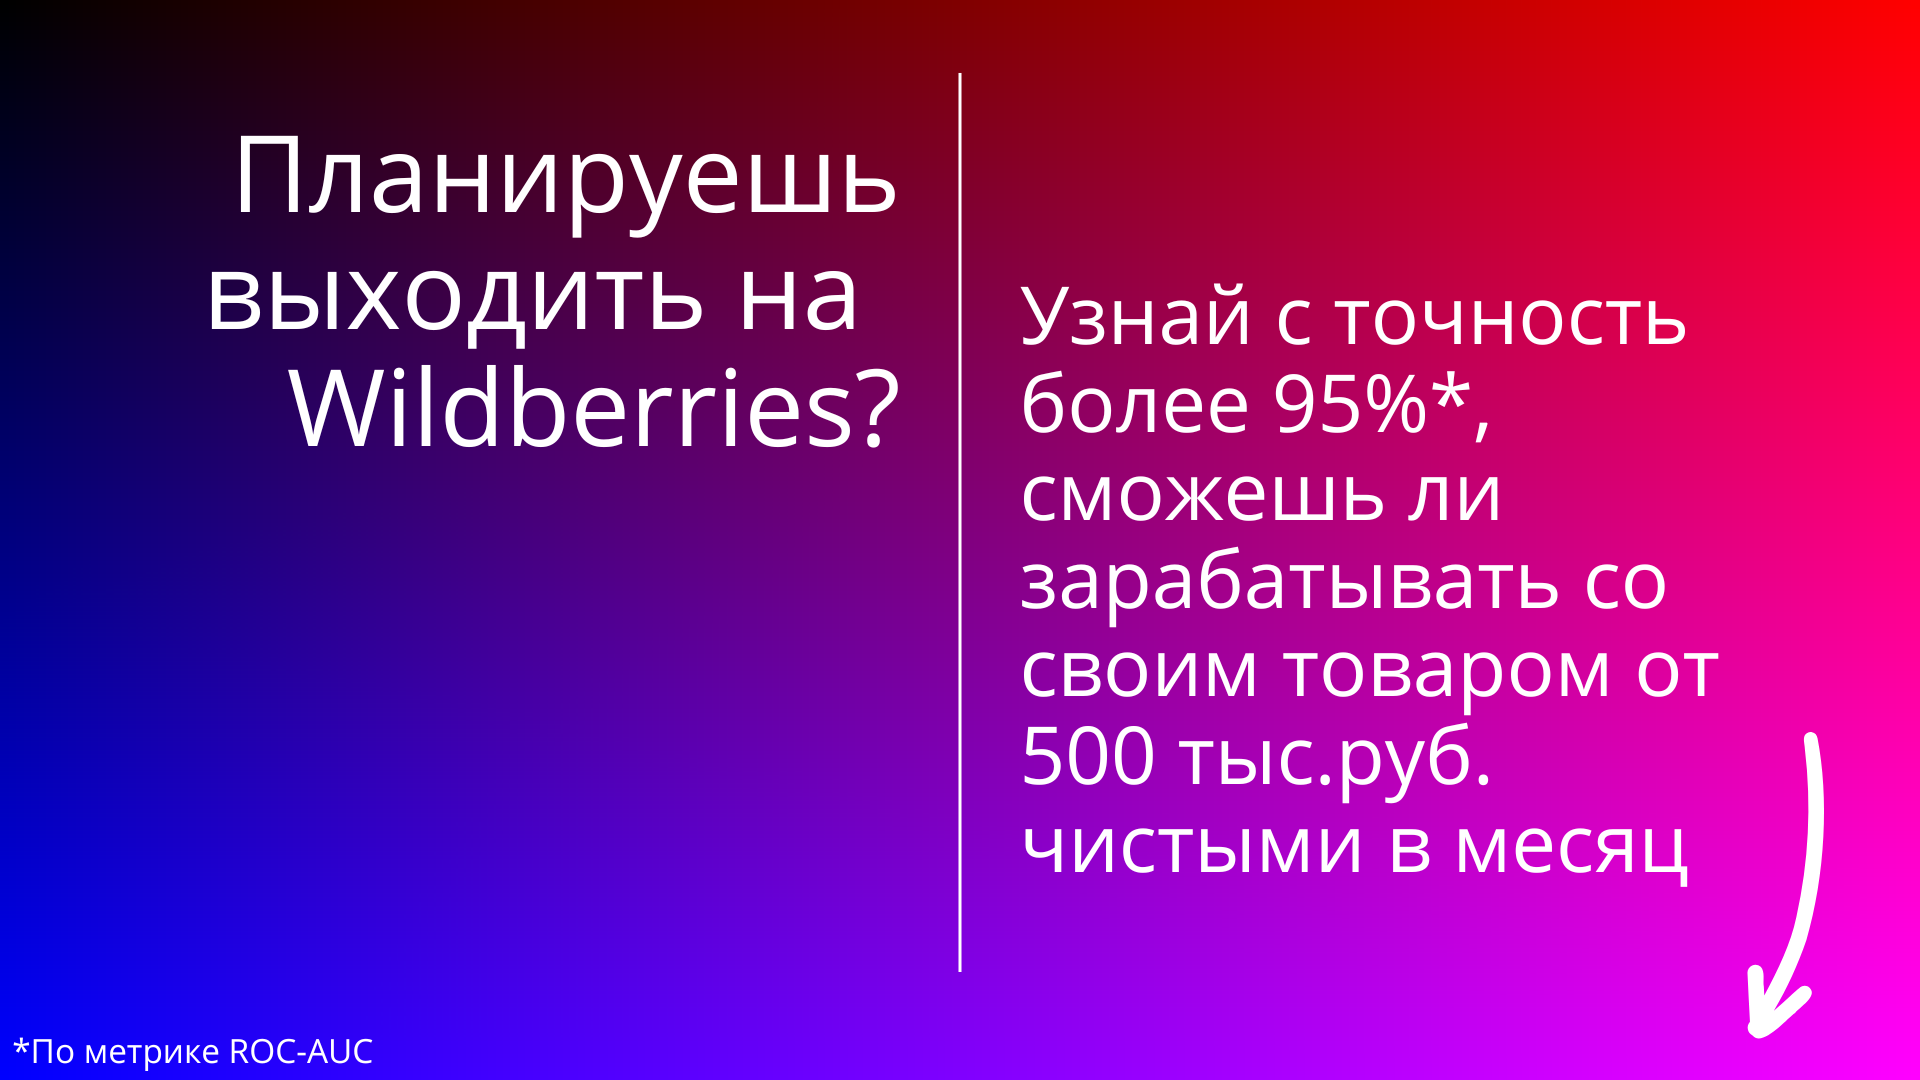

In [2]:
Image(filename='Обложка.png')

**Задача:**

Многие селлеры при выходе на маркетплейс задаются только одним вопросом: Купил бы я сам этот товар? 

Но не учитывают потенциал рынка, а также тип юридического лица или количества фото в карточке товара.

Данная ML модель, основываясь на потенциале рынка и вводных селлера, ответит на вопрос:

Можно ли с выбранным товаром зарабатывать от 500 тыс.руб в месяц?

**Цель:**

Решить задачу бинарной классификации, с точность более 95%(по метрике ROC-AUC).

При этом селлер должен заполнить всего 5 базовых пунктов:
- Вид товара (раздел/категория/подкатегория/наименование);
- Страна производства; 
- Тип юридического лица; 
- Количество фото; 
- Наличие видео в карточке товара. 

**Описание DataFrame:**

Данные загружены с сайта https://mpstats.io/ (специализирующегося на парсинге актуальных данных из маркетплейсов).

Состоит из информации о ТОП 100 самых продаваемых товарах(с самой большой выручкой) во всех 23 категориях (353 подкатегориях) за текущий год, на самом крупном маркетплейсе в России - Wildberries.    

Описание исходных групп столбцов (описание итоговых 11-ти столбцов для ML-модели далее):
- SKU - артикул;
- Name, Subject, Brand, Seller - наименование (товара, типа, бренда, юр.лица);
- Price - ценa(финальная, минимальная, максимальная, средняя, базовая, медианная);
- Sales, Balance - количество (проданных товаров за год, товара в наличии на складе wb и у селлера);
- Revenue - выручка (за год, в день, потеницальная в год);
- Color - цвет;
- Gender - пол;
- Comment - комментарии (дата первого, количество, средняя оценка);
- Purchase - процент выкупа (до и после возврата товара);
- Rating - рейтинг (средний, по оценке mpstat);
- Basic Sale - базовая скидка;
- Country - страна производства;
- Category - категории (позиция, количество);
- First Date - дата появляния карточки на wb;
- SPP - скидка постоянного покупателя(процент, сумма);
- Profit - упущенная выручка (сумма, процент);
- Days - количество дней товара (в наличии, с продажами);
- Average - оборачиваемость товара за год (продан, выкуплен)
- FBS - работа по схеме, при которой поставщик сам доставляет товар в ближайший пункт;
- URL - ссылка на товар;
- Pics Count, Has 3D, Hax Video  - количество классического фото, 3D и видео на карточке;
- Turnover	- оборот товаров (в год, в день);
- Section, Category, Subcategory, Type, Model - раздел, категория, подкатегория, тип, модель. 

Подробное описание каждого столбца доступно по ссылке: https://disk.yandex.ru/i/uY_SAhIar9hjRA                                 

# Data import and preprocessing

In [3]:
df_initial = pd.read_csv('wb_284692.csv')

In [4]:
df_initial[:5]

,SKU,Name,Final price,Sales,Revenue,Revenue average,Revenue potential,Color,Gender,First Comment Date,...,Has 3D,Hax Video,Turnover,Turnover days,Categories Last Count,Section,Category,Subcategory,Type,Model
0,148340239,NaN,11890,159,1718784,"4696,1311","4493392,4571",NaN,NaN,2023-04-18,...,0,1,"22,71",16,2,Автотовары,OFFroad,Лебедка автомобильная,NaN,NaN
1,65980217,NaN,3010,606,1665900,"4551,6393","1858900,6098",NaN,NaN,2022-03-28,...,0,1,"50,5",7,2,Автотовары,OFFroad,Лебедка автомобильная,NaN,NaN
2,161704634,NaN,8282,83,684986,"1871,5464","10446036,5",NaN,NaN,2023-05-29,...,0,0,"4,88",75,2,Автотовары,OFFroad,Лебедка электрическая переносная,NaN,NaN
3,143132161,NaN,4319,136,588956,"1609,1694","988797,6881",NaN,NaN,2023-01-31,...,0,1,"1,99",184,2,Автотовары,OFFroad,Антипробуксовочное приспособление,NaN,NaN
4,60402549,NaN,1208,454,534359,"1459,9973","763966,3828",NaN,NaN,2022-04-08,...,0,1,0,0,0,Автотовары,OFFroad,Антипробуксовочное приспособление,NaN,NaN


In [5]:
# необходимые столбцы
df = df_initial[[
    'Section', 'Category', 'Subcategory', 'Type', 'Model', 'Name', 'Country',
    'Seller', 'Pics Count', 'Hax Video', 'Revenue potential', 'Comments', 'Rating'
]]

In [6]:
def replacing_space_on_underscore(column_name: str) -> str:
    """
    Замена в названиях столбцов пробелов на нижнее подчеркивание
    """
    return column_name.replace(' ', '_')

In [7]:
df.columns = df.columns.map(replacing_space_on_underscore)

In [8]:
def replacing_comma_on_dot(column: str) -> str:
    """
    Замена в столбцах с будущими числами, запятых на точки
    """
    return column.replace(',', '.')

In [9]:
columns_to_int_convert = ['Revenue_potential']

In [10]:
for column in columns_to_int_convert:
    df[[column]] = df[[column]].applymap(replacing_comma_on_dot)

In [11]:
def convert_to_float_int(column: str) -> int:
    """
    Перевод столбцов сначала во float, потом в int
    """
    convert_to_float = column.astype(float)
    convert_to_int = convert_to_float.astype(int)
    return convert_to_int

In [12]:
for column in columns_to_int_convert:
    df[[column]] = convert_to_float_int(df[[column]])

In [13]:
# в столбце Seller вместо наименований юр.лиц, создание меток ИП или ООО
df['Seller'] = df['Seller'].apply(lambda x: 1
                                  if isinstance(x, str) and 'ИП' in x else 0)

In [14]:
# сортировка столбцов в удобном для чтения порядке
desired_order = [
    'Section', 'Category', 'Subcategory', 'Type', 'Model', 'Name', 'Country',
    'Seller', 'Pics_Count', 'Hax_Video', 'Comments', 'Rating', 'Revenue_potential'
]
df = df[desired_order]

In [15]:
def categorize_income(income: Union[int, float]) -> int:
    """
    Разделение на 2 класса. 
    Если меньше 24 млн потенциальной выручки в год (это 2 млн выручки
    в месяц, при средней маржинальности товаров в 25% - 500 тыс. 
    чистой прибыли в месяц) - 0 класс, больше 1 класс.
    """
    if income <= 24000000:
        return 0
    else:
        return 1

In [16]:
df['target'] = df['Revenue_potential'].apply(categorize_income)

In [17]:
# удаление, коррелирующей с целеевой переменной - потенциальной выручки
df = df.drop(columns=['Revenue_potential'])

In [18]:
# сохранение итогово DataFrame в csv, для дальнейшего обучения модели в следующем ipynb
df.to_csv('df.csv', index=False)

# Description and statistics

**Описание полей**

- Section - раздел;
- Category - категория; 
- Subcategory - подкатегория; 
- Type - тип; 
- Model - модель; 
- Name - наименование;
- Country - страна производства;
- Seller - тип продовца(0 - ООО, 1 - ИП);
- Pics_Count - кол-во фото;
- Hax_Video - наличие видео;
- Comments - кол-во комментариев;
- Rating - рейтинг отзывов;
- target - класс(0 - прибыль меньше 500 тыс.руб в мес., 1 - больше).

In [19]:
df

,Section,Category,Subcategory,Type,Model,Name,Country,Seller,Pics_Count,Hax_Video,Comments,Rating,target
0,Автотовары,OFFroad,Лебедка автомобильная,NaN,NaN,NaN,NaN,1,7,1,14,4,0
1,Автотовары,OFFroad,Лебедка автомобильная,NaN,NaN,NaN,Россия,1,14,1,78,5,0
2,Автотовары,OFFroad,Лебедка электрическая переносная,NaN,NaN,NaN,Китай,0,3,0,36,5,0
3,Автотовары,OFFroad,Антипробуксовочное приспособление,NaN,NaN,NaN,Россия,1,9,1,30,5,0
4,Автотовары,OFFroad,Антипробуксовочное приспособление,NaN,NaN,NaN,NaN,1,7,1,30,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35136,Женщинам,Юбки,NaN,NaN,NaN,NaN,Россия,1,6,0,1061,5,0
35137,Женщинам,Юбки,NaN,NaN,NaN,NaN,Россия,1,13,1,1461,5,0
35138,Женщинам,Юбки,NaN,NaN,NaN,NaN,Турция,1,11,1,451,5,1
35139,Женщинам,Юбки,NaN,NaN,NaN,NaN,Турция,1,6,1,508,5,1


In [20]:
df.shape

(35141, 13)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35141 entries, 0 to 35140
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Section      35141 non-null  object
 1   Category     35141 non-null  object
 2   Subcategory  27154 non-null  object
 3   Type         9559 non-null   object
 4   Model        1075 non-null   object
 5   Name         238 non-null    object
 6   Country      28564 non-null  object
 7   Seller       35141 non-null  int64 
 8   Pics_Count   35141 non-null  int64 
 9   Hax_Video    35141 non-null  int64 
 10  Comments     35141 non-null  int64 
 11  Rating       35141 non-null  int64 
 12  target       35141 non-null  int64 
dtypes: int64(6), object(7)
memory usage: 3.5+ MB


In [22]:
df.describe()

,Seller,Pics_Count,Hax_Video,Comments,Rating,target
count,35141.000000,35141.000000,35141.000000,35141.000000,35141.000000,35141.000000
mean,0.489229,10.162403,0.508608,4258.065621,4.795709,0.240801
std,0.499891,5.709297,0.499933,7905.281878,0.676216,0.427576
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,6.000000,0.000000,331.000000,5.000000,0.000000
50%,0.000000,9.000000,1.000000,1287.000000,5.000000,0.000000
75%,1.000000,13.000000,1.000000,4347.000000,5.000000,0.000000
max,1.000000,30.000000,1.000000,65179.000000,5.000000,1.000000


Селлеров с ООО и ИП приблизительно поровну;                                          
Количество фотографий в карточках товара в среднем около 10 шт;                                                              
Наличие или отсутствие видео в карточках товара приблизительно поровну.                                                           
Комментариев в среднем 4 тысячи шт;                                                        
Средний рейтинг карточки 4,79 балла.

In [23]:
df.describe(include=object)

,Section,Category,Subcategory,Type,Model,Name,Country
count,35141,35141,27154,9559,1075,238,28564
unique,23,353,1585,972,111,21,69
top,Книги,OFFroad,Православие,Одежда,Костюм спортивный,Костюм спортивный,Россия
freq,2600,100,262,253,192,52,14792


Самые популярные в:                                                                              
 разделах - книги;                                                                                           
 категориях - OFFroad;                                                  
 подкатегориях - православие;                                        
 типах -  одежда;                                                          
 моделях - спортивный костюм;                                                  
 наименованиях - спортивный костюм;                                        
 странах -  Россия.
 
Все столбцы имеют множество уникальных значений.

# EDA

##### Анализ целевой переменной

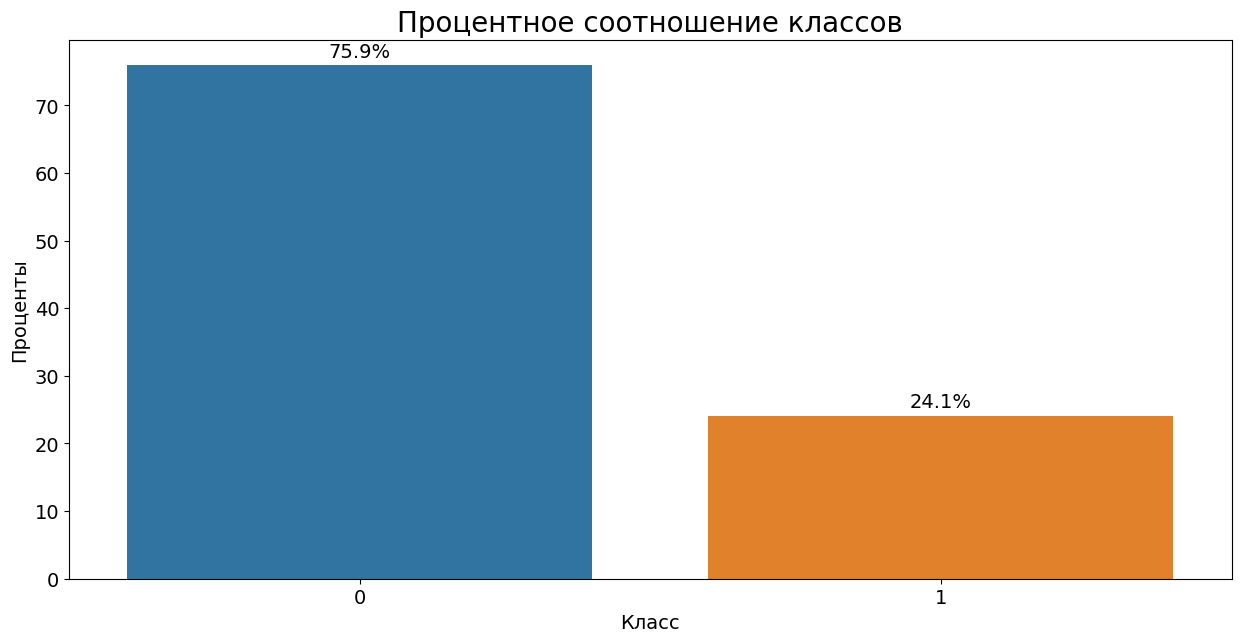

In [24]:
def plot_text(ax: plt.Axes):
    """
    Вывод текста на графике barplot
    """
    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        ax.annotate(
            percentage,  # текст
            # координата xy
            (p.get_x() + p.get_width() / 2., p.get_height()),
            # центрирование
            ha='center',
            va='center',
            xytext=(0, 10),
            # точка смещения относительно координаты
            textcoords='offset points',
            fontsize=14)


# нормирование на размер датасета
norm_target = (df.target.value_counts(
    normalize=True).mul(100).rename('percent').reset_index())

plt.figure(figsize=(15, 7))
ax = sns.barplot(x='target', y='percent', data=norm_target)

plot_text(ax)

plt.title('Процентное соотношение классов', fontsize=20)
plt.xlabel('Класс', fontsize=14)
plt.ylabel('Проценты', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

##### 1 гипотеза:
##### Большая прибыль у товаров из  категории - товары для дома, а  маленькая прибыль у товаров из категории - аксессуары?

Большая прибыль у товаров из категорий - женщинам, спорт, красота и только после товары для дома;

Маленькая прибыль у товаров из категорий - книги, игрушки и после аксессуары.

In [25]:
def barplot_group_no_percent_and_rotation(df_data: pd.DataFrame, col_main: str,
                                          col_group: str, title: str) -> None:
    """
    Построение barplot с нормированными данными с выводом значений на графике
    """

    plt.figure(figsize=(15, 7))

    data = (df_data.groupby(
        [col_group])[col_main].value_counts(normalize=True).rename(
            'percentage').mul(100).reset_index().sort_values(col_group))

    ax = sns.barplot(x=col_main,
                     y='percentage',
                     hue=col_group,
                     data=data,
                     palette='rocket')

    for p in ax.patches:
        percentage = '{:.0f}%'.format(p.get_height())
        ax.annotate(
            percentage,  # текст
            (p.get_x() + p.get_width() / 2., p.get_height()),  # координата xy
            ha='center',  # центрирование
            va='center',
            xytext=(0, 7),
            textcoords='offset points',  # точка смещения относительно координаты
            fontsize=9)

    plt.title(title, fontsize=16)
    plt.ylabel('Percentage', fontsize=14)
    plt.xlabel(col_main, fontsize=14)
    plt.xticks(rotation=45)
    plt.show()

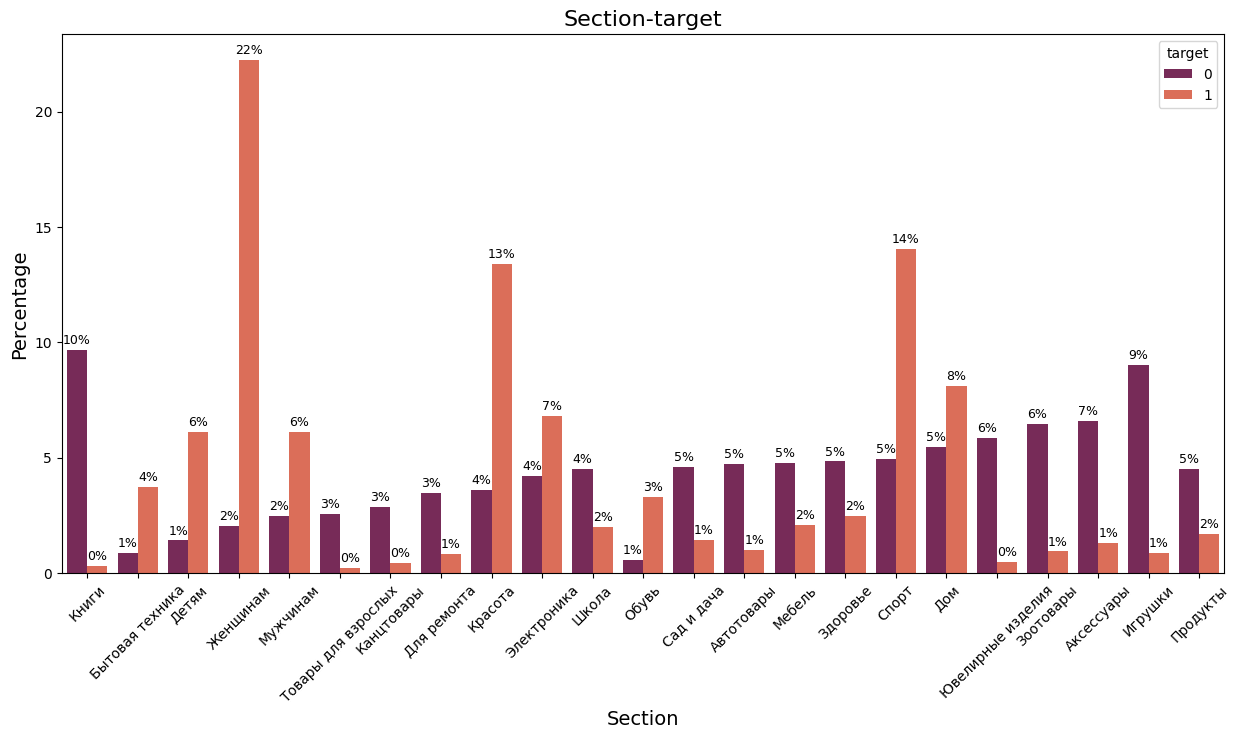

In [26]:
barplot_group_no_percent_and_rotation(df, 'Section', 'target',
                                      'Section-target')

##### 2 гипотеза:
##### Больше всего во всех классах продают товары из Китая? И на них наибольшая прибыль?

В обеих классах преобладают Российские товары.                                                                        
Наибольшая и наименьшая прибыль так же на товарах из России.

In [27]:
country_counts = df['Country'].value_counts()

In [28]:
top_countries = country_counts.head(5)

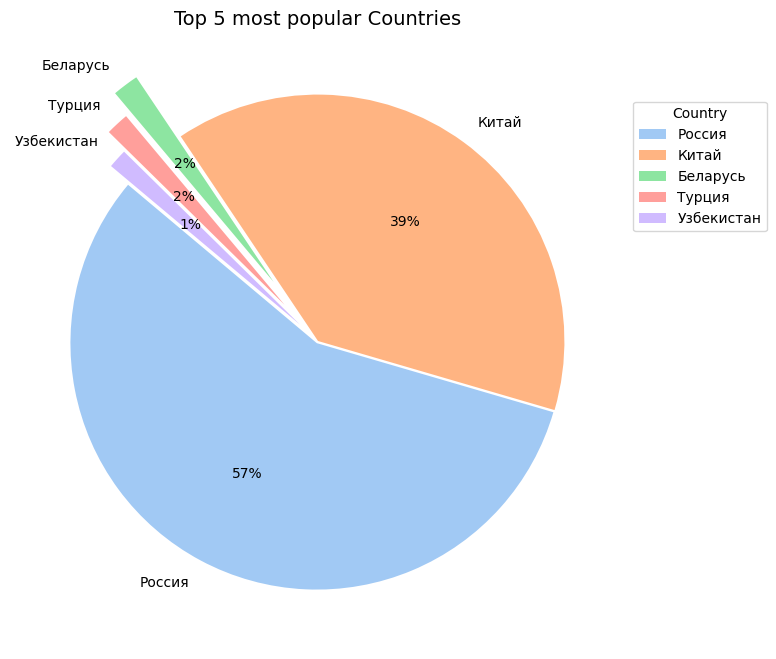

In [29]:
plt.figure(figsize=(9, 8))

myexplode = [0.01, 0.0, 0.3, 0.2, 0.1]
plt.pie(top_countries,
        labels=top_countries.index,
        autopct='%1.f%%',
        startangle=140,
        colors=sns.color_palette('pastel'),
        explode=myexplode)

plt.title('Top 5 most popular Countries', fontsize=14)
plt.legend(title='Country',
           labels=top_countries.index,
           loc='best',
           bbox_to_anchor=(1, 0.9))
plt.show()

In [30]:
df_County = df[(df['Country'] == 'Россия') | (df['Country'] == 'Китай')]

In [31]:
def barplot_group(df_data: pd.DataFrame, col_main: str, col_group: str,
                  title: str, palette: str) -> None:
    """
    Построение barplot с нормированными данными с выводом значений на графике
    """

    plt.figure(figsize=(15, 6))

    data = (df_data.groupby(
        [col_group])[col_main].value_counts(normalize=True).rename(
            'percentage').mul(100).reset_index().sort_values(col_group))

    ax = sns.barplot(x=col_main,
                     y='percentage',
                     hue=col_group,
                     data=data,
                     palette=palette)

    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        ax.annotate(
            percentage,  # текст
            (p.get_x() + p.get_width() / 2., p.get_height()),  # координата xy
            ha='center',  # центрирование
            va='center',
            xytext=(0, 7),
            textcoords='offset points',  # точка смещения относительно координаты
            fontsize=12)

    plt.title(title, fontsize=16)
    plt.ylabel('Percentage', fontsize=14)
    plt.xlabel(col_main, fontsize=14)
    plt.show()

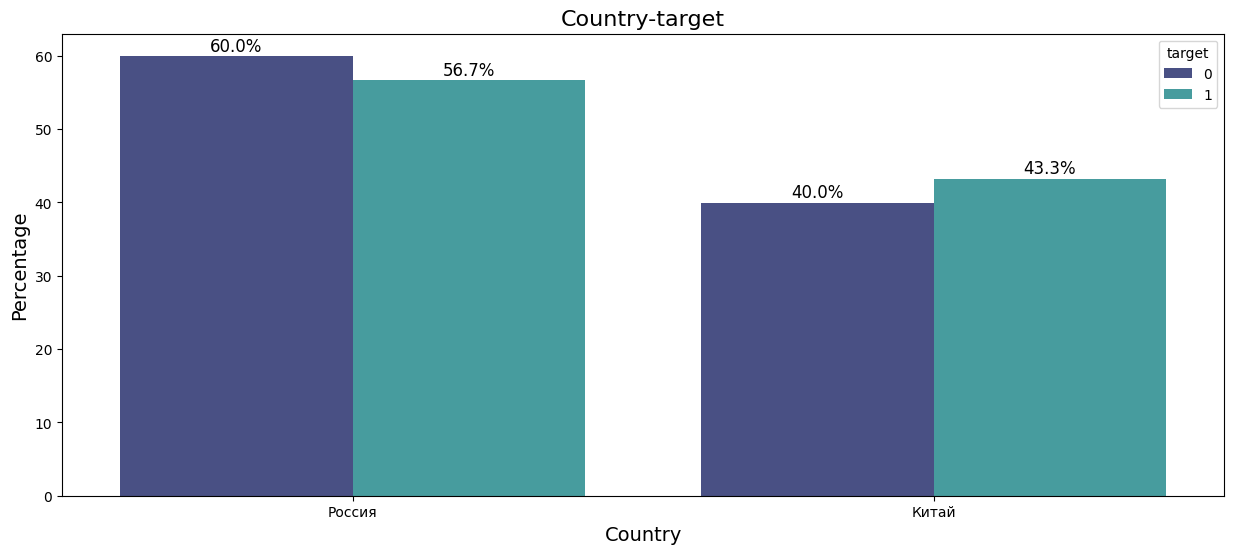

In [32]:
barplot_group(df_County, 'Country', 'target', 'Country-target', 'mako')

##### 3 гипотеза:
##### Селлеры с большой прибылью работают с ООО,  а с маленькой с ИП?

Селлеры с большой и с маленькой прибылью больше всего работают с ООО, чем с ИП, но разница небольшая, всего 1-2%.

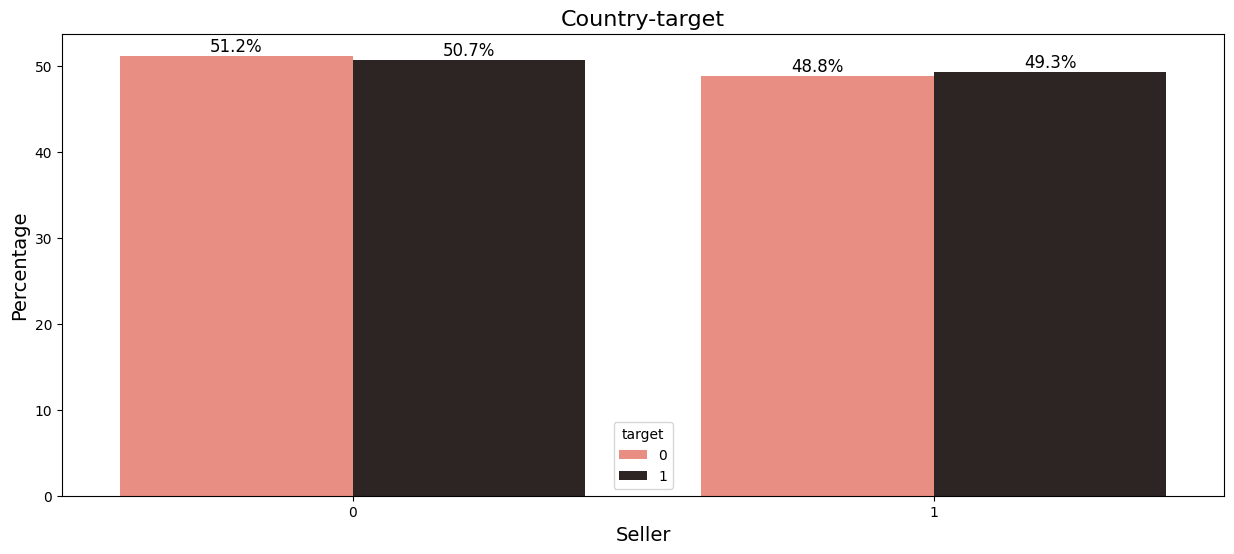

In [33]:
barplot_group(df, 'Seller', 'target', 'Country-target', 'dark:salmon_r')

##### 4 гипотеза:
##### Количество фотографий никак не влияет на прибыль, в обоих классах в среднем по 10 шт?

Влияет, при чем у товаров с большой прибылью около 12 шт, а с маленькой около 8 шт.

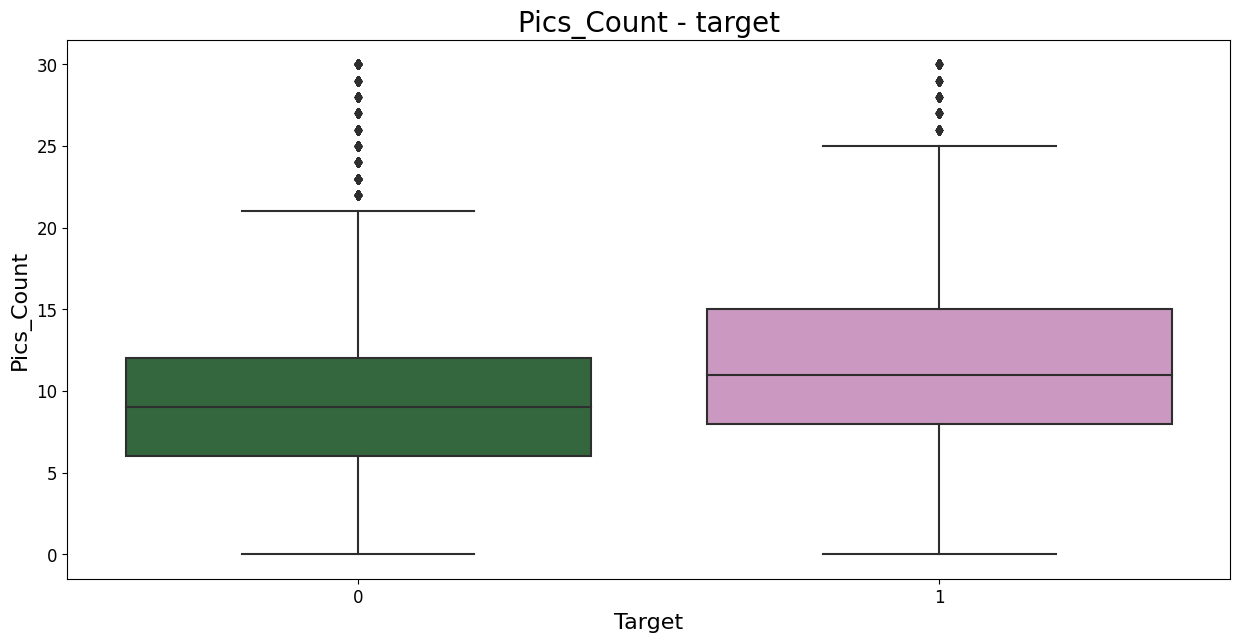

In [34]:
plt.figure(figsize=(15, 7))

sns.boxplot(y='Pics_Count', x='target', data=df, palette='cubehelix')

plt.title('Pics_Count - target', fontsize=20)
plt.xlabel('Target', fontsize=16)
plt.ylabel('Pics_Count', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

##### 5 гипотеза:
##### Видео в карточках товара присутсвует только у селлеров с маленькой прибылью, так как селлеры с большой прибылью сосредоточены больше на производстве, и меньше времени уделяют развитию товара?

Наоборот, у селлеров с большой прибыль, как правило присутствует видео, а с маленькой прибылью отсутствует.

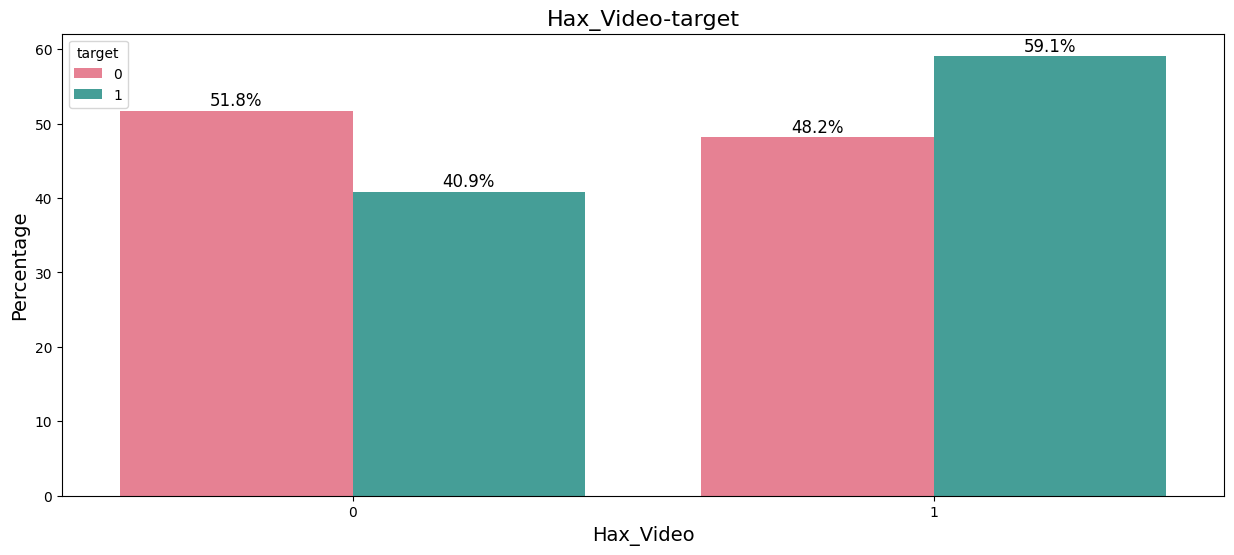

In [35]:
barplot_group(df, 'Hax_Video', 'target', 'Hax_Video-target', 'husl')

##### 6 гипотеза:
##### У селлеров с большой прибылью большее количество комментариев на товарах, чем у селлеров с маленькой прибылью?

Да, у селлеров с большой прибылью большее количество комментариев на товарах, в среднем около 5 тысяч, а у селлеров с маленькой прибылью меньше 1 тысячи на каждом товаре.

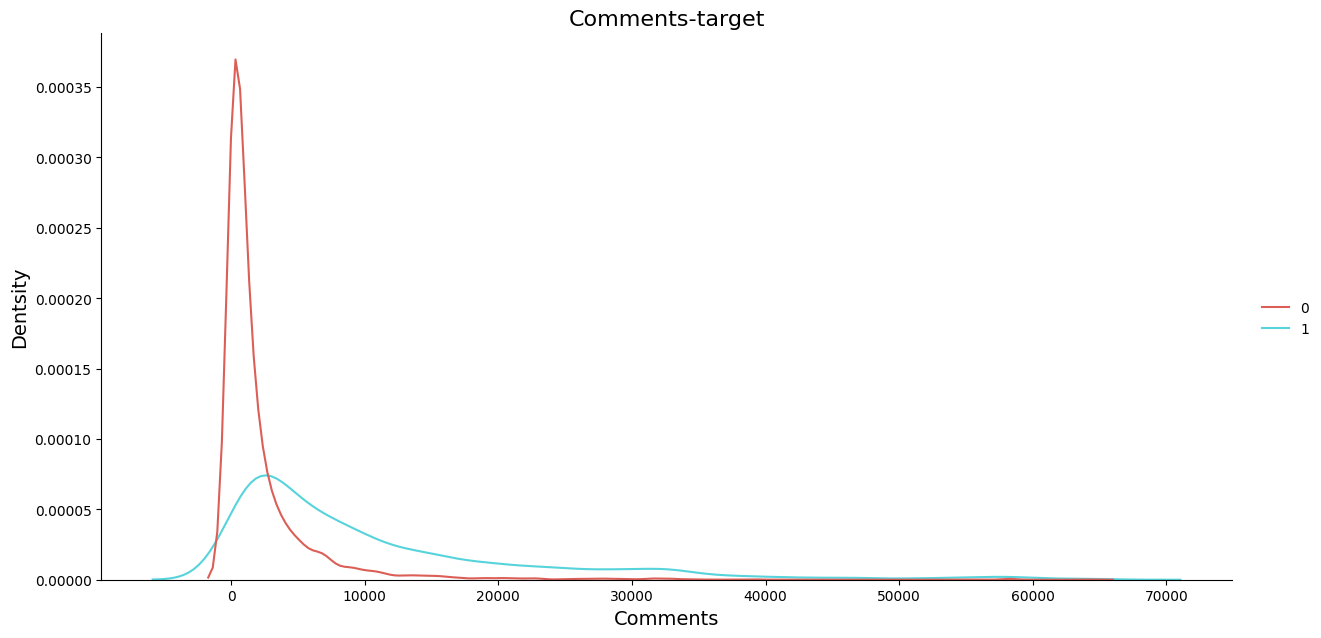

In [36]:
sns.displot(
    {
        "0": df[df.target == 0].Comments,
        "1": df[df.target == 1].Comments,
    },
    kind="kde",
    common_norm=False,
    height=6,
    aspect=2.1,
    palette='hls')

plt.title('Comments-target', fontsize=16)
plt.xlabel('Comments', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)
plt.show()

##### 7 гипотеза:
##### У селлеров с большой прибылью рейтинг отзывов выше, чем у селлеров с маленькой прибылью?

Да, у селлеров с большой прибылью больший процент оценок с 5-ти баллами, меньший процент с оценками в 4 балла, и практический нет оценок от 0-я до 3-х баллов, в отличии от селлеров с маленькой прибылью.

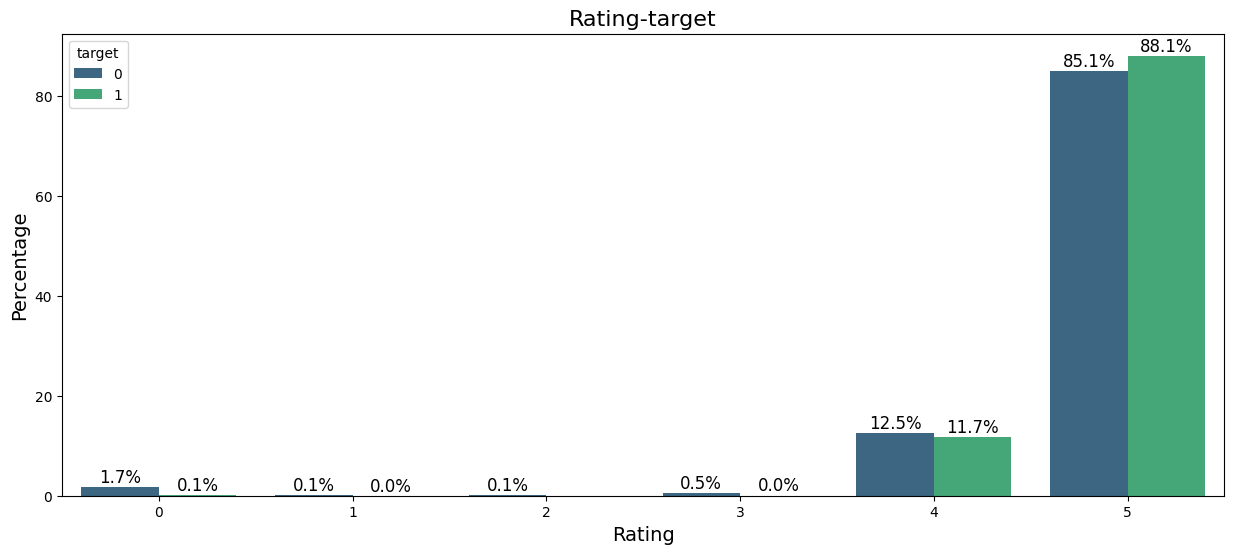

In [37]:
barplot_group(df, 'Rating', 'target', 'Rating-target', 'viridis')